# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import csv
import random
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from scipy.misc import imread, imsave, imresize
from skimage import exposure
import warnings
import cv2
import pickle

In [2]:
# Load pickled data
# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'
class_name_file = 'signnames.csv'


with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
n_classes = len(np.unique(y_test))

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
import numpy as np
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
# count how many samples per classification the training set has
classes_lineup = []
count_per_class = [0]*n_classes
running_counts = [0]*n_classes
class_names = []

for i in range(0, len(y_train)):
    if y_train[i] not in classes_lineup:
        classes_lineup.append(y_train[i])
    count_per_class[y_train[i]]+=1

count_before = 0
for n in classes_lineup:
    running_counts[n] = count_per_class[n] + count_before
    count_before = running_counts[n]
    
with open(class_name_file) as _f:
    rows = csv.reader(_f, delimiter=',')
    next(rows, None)
    for i, row in enumerate(rows):
        assert(i==int(row[0]))
        class_names.append(row[1]) 

In [5]:
# data set table

print("-----------------------------------------------------------")
print("|%-*s | RUNNING | #   | NAME'" % (6, 'COUNT'))
print("-----------------------------------------------------------")

for n in classes_lineup:
    print("|%-*s | %-*s | %-*s | %s " % (6, count_per_class[n], 7, running_counts[n], 3, n, class_names[n]))

-----------------------------------------------------------
|COUNT  | RUNNING | #   | NAME'
-----------------------------------------------------------
|210    | 210     | 41  | End of no passing 
|690    | 900     | 31  | Wild animals crossing 
|330    | 1230    | 36  | Go straight or right 
|540    | 1770    | 26  | Traffic signals 
|450    | 2220    | 23  | Slippery road 
|1980   | 4200    | 1   | Speed limit (30km/h) 
|300    | 4500    | 40  | Roundabout mandatory 
|330    | 4830    | 22  | Bumpy road 
|180    | 5010    | 37  | Go straight or left 
|360    | 5370    | 16  | Vehicles over 3.5 metric tons prohibited 
|1260   | 6630    | 3   | Speed limit (60km/h) 
|180    | 6810    | 19  | Dangerous curve to the left 
|1770   | 8580    | 4   | Speed limit (70km/h) 
|1170   | 9750    | 11  | Right-of-way at the next intersection 
|210    | 9960    | 42  | End of no passing by vehicles over 3.5 metric tons 
|180    | 10140   | 0   | Speed limit (20km/h) 
|210    | 10350   | 32  | End o

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [6]:
def show_images(X, end, total, images_per_row = 30, images_per_col = 15,
                H = 20, W = 1, its_gray = False):    
    number_of_images = images_per_row * images_per_col
    figure, axis = plt.subplots(images_per_col, images_per_row, figsize=(H, W))
    figure.subplots_adjust(hspace = .2, wspace=.001)
    axis = axis.ravel()
    
    for i in range(number_of_images):
        index = random.randint(end - total, end - 1)
        image = X[index]
        axis[i].axis('off')
        if its_gray:
            axis[i].imshow(image.reshape(32,32), cmap='gray')
        else:
            axis[i].imshow(image)

In [7]:
def plot_histogram(data, name):
    class_list = range(n_classes)
    label_list = data.tolist()
    counts = [label_list.count(i) for i in class_list]
    plt.bar(class_list, counts)
    plt.xlabel(name)
    plt.show()

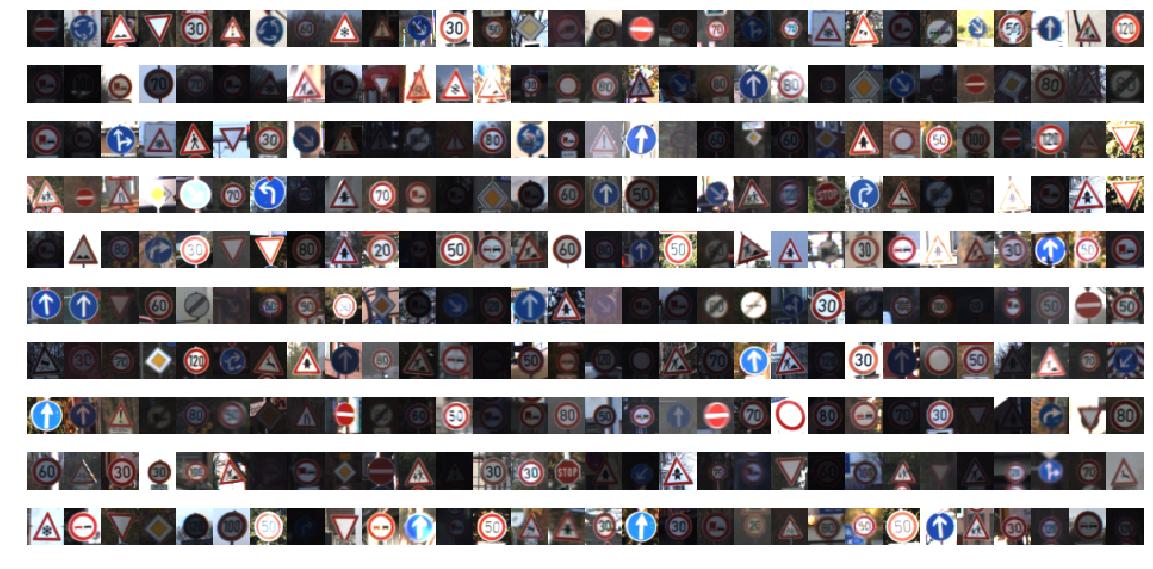

In [8]:
#PLOT 300 RANDOM IMAGES from training set
show_images(X_train, len(X_train), len(X_train), 
            images_per_row = 30, images_per_col = 10, 
            H = 20, W = 10)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


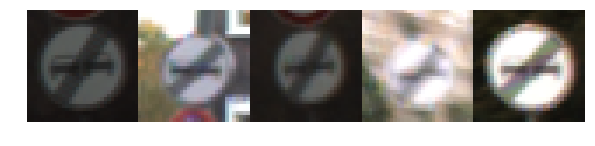

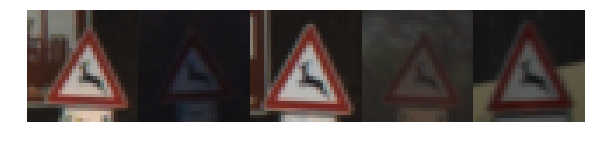

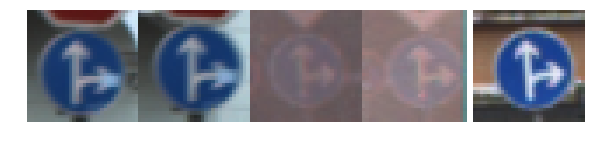

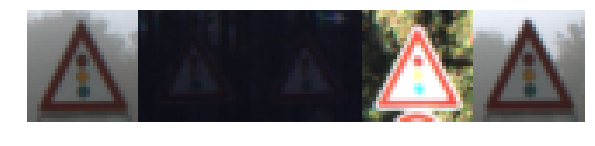

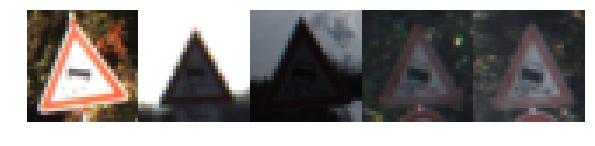

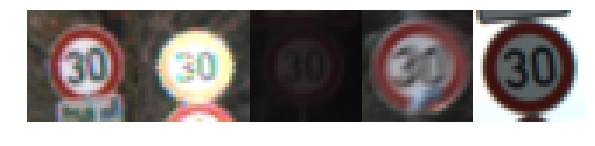

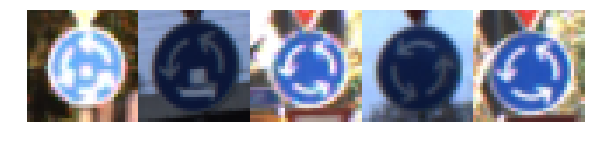

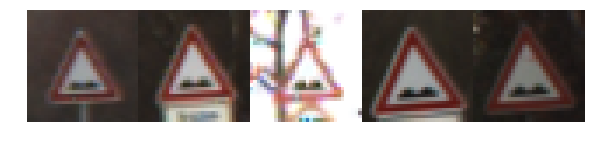

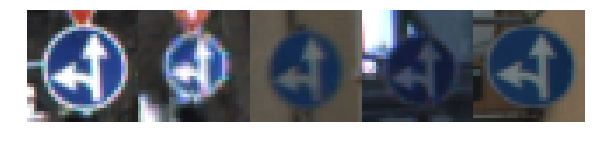

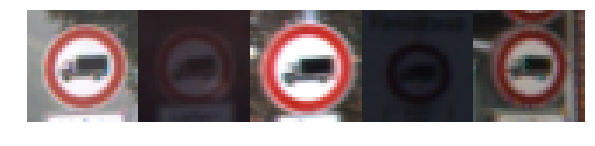

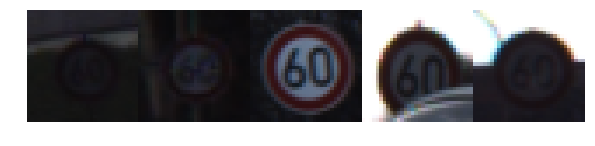

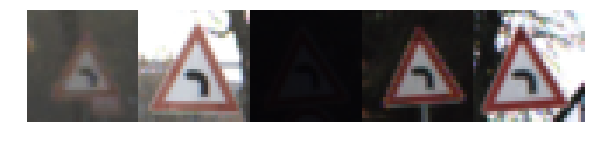

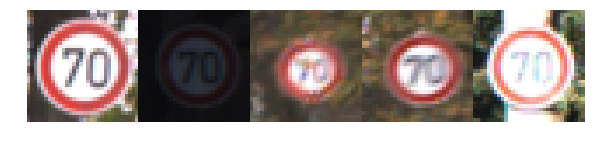

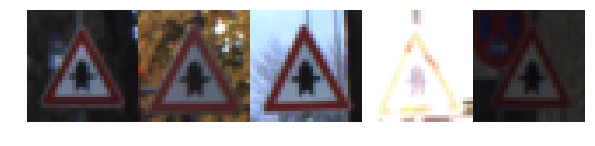

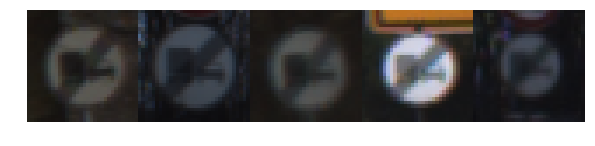

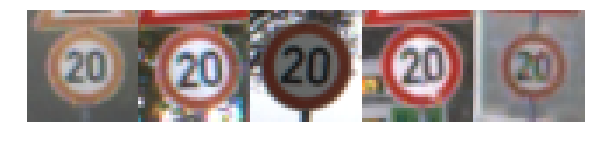

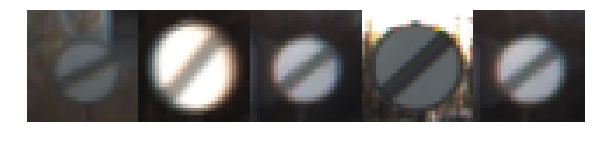

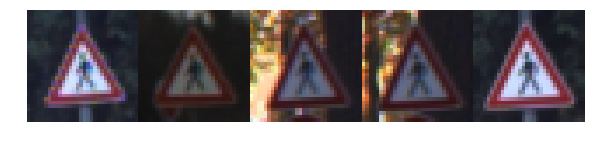

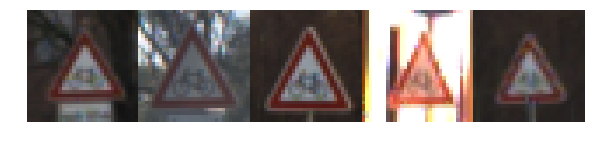

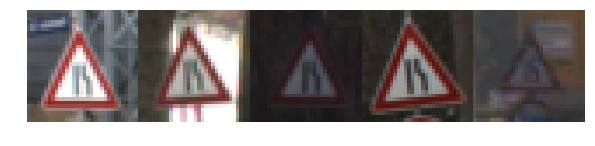

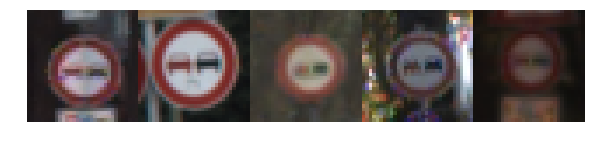

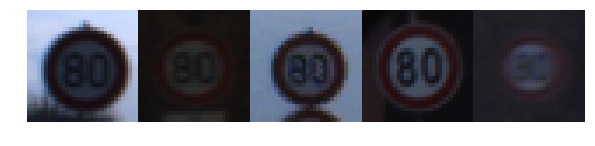

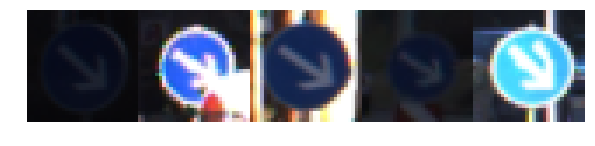

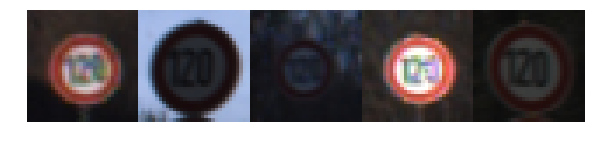

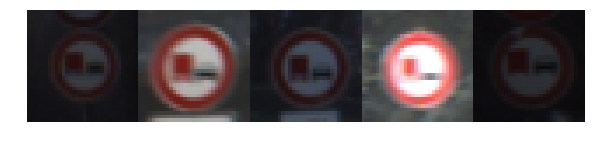

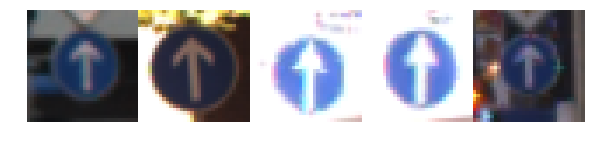

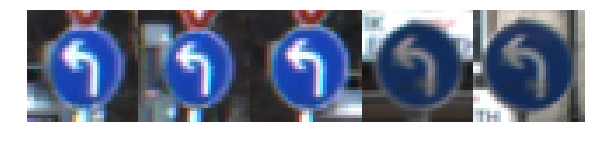

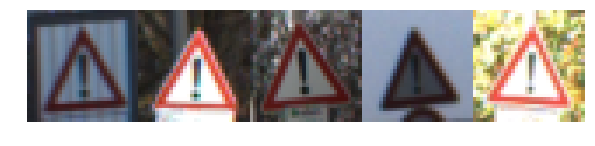

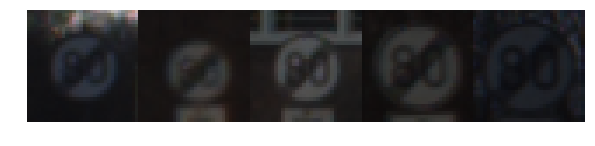

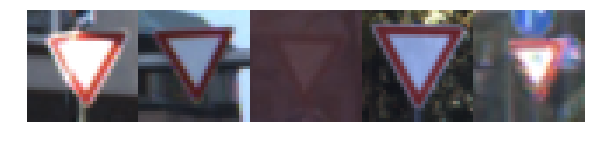

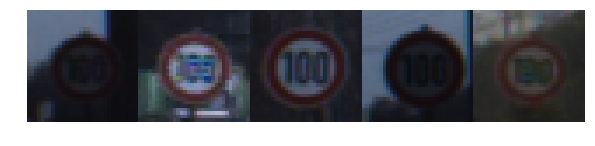

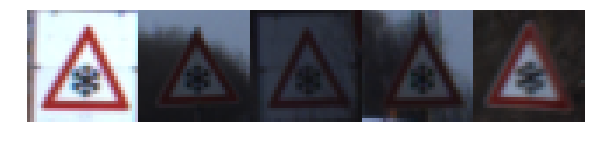

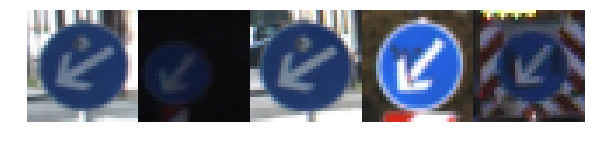

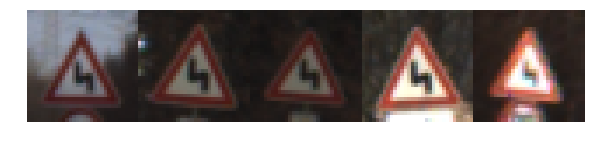

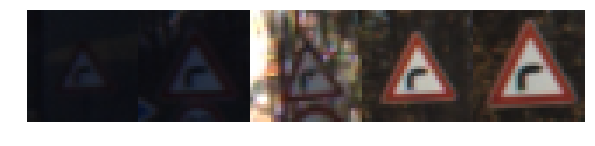

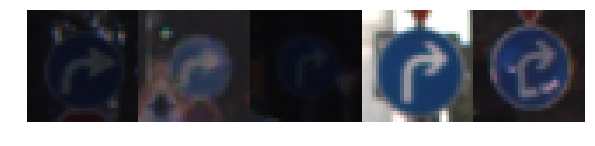

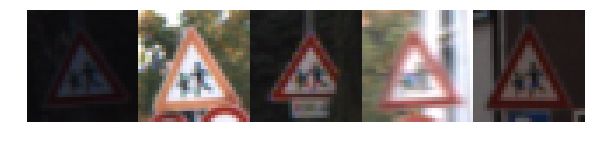

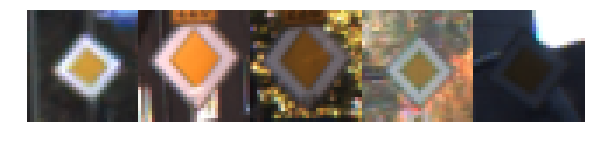

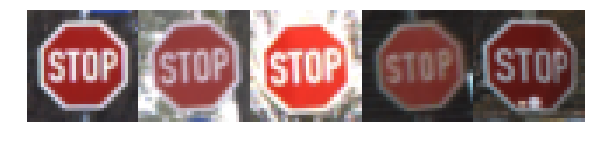

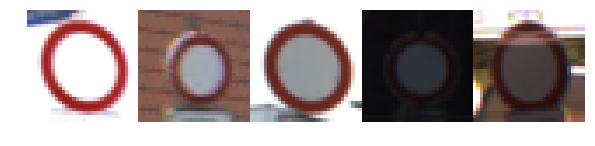

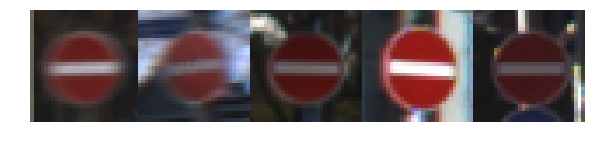

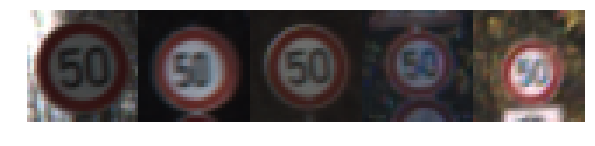

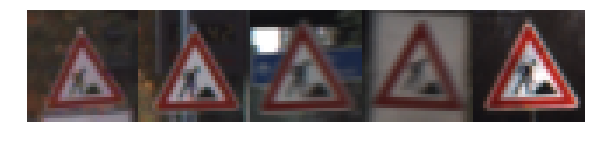

In [9]:
#PLOT 5 RANDOM IMAGES each per classification
for n in classes_lineup:
    show_images(X_train, running_counts[n], count_per_class[n], 
                images_per_row = 5, images_per_col = 1, H = 10, W = 10)

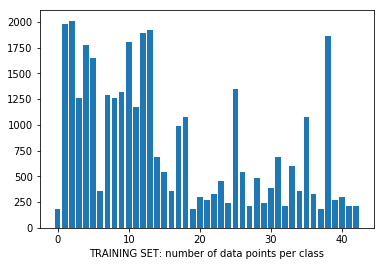

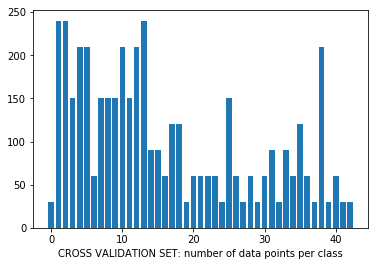

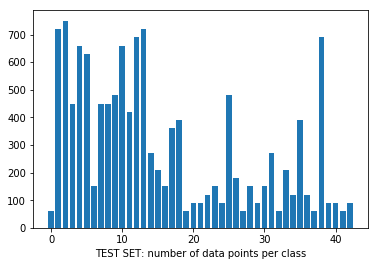

In [10]:
#PLOT HISTOGRAM OF EACH DATA SET
plot_histogram(y_train, name = "TRAINING SET: number of data points per class")
plot_histogram(y_valid, name = "CROSS VALIDATION SET: number of data points per class")
plot_histogram(y_test, name = "TEST SET: number of data points per class")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [11]:
# grayscale converter
def preprocess(X):
    '''
    - convert images to grayscale, 
    - scale from [0, 255] to [0, 1] range, 
    - use localized histogram equalization as images differ 
      in brightness and contrast significantly
    ADAPTED FROM: http://navoshta.com/traffic-signs-classification/
    '''

    #Convert to grayscale, e.g. single channel Y
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]

    #Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)
    
    #adjust histogram
    for i in range(X.shape[0]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X[i] = exposure.equalize_adapthist(X[i]) 
            
    return X

def reshape(x): # Add a single grayscale channel
    return x.reshape(x.shape + (1,))

In [14]:
training_preprocessed_file = "data/X_train_preprocessed.p"
validation_preprocessed_file = "data/X_valid_preprocessed.p"
testing_preprocessed_file = "data/X_test_preprocessed.p" 

print("Preprocessing the data to improve feature extraction...")
print("This might take a while...")

X_preprocessed = preprocess(X_train)
X_train_preprocessed = reshape(X_preprocessed)
print("training set preprocessing complete!", X_train_preprocessed.shape)

X_valid_preprocessed = preprocess(X_valid)
X_valid_preprocessed = reshape(X_valid_preprocessed)
print("cross validation set preprocessing complete!", X_valid_preprocessed.shape)

X_test_preprocessed = preprocess(X_test)
X_test_preprocessed = reshape(X_test_preprocessed)
print("test set preprocessing complete!", X_test_preprocessed.shape)

Preprocessing the data to improve feature extraction...
This might take a while...
training set preprocessing complete! (34799, 32, 32, 1)
cross validation set preprocessing complete! (4410, 32, 32, 1)
test set preprocessing complete! (12630, 32, 32, 1)


In [15]:
# Save the preprocessed data set, so we don't have to preprocess it everytime 

pickle.dump(X_train_preprocessed, open(training_preprocessed_file, "wb" ))
pickle.dump(X_valid_preprocessed, open(validation_preprocessed_file, "wb" ))
pickle.dump(X_test_preprocessed, open(testing_preprocessed_file, "wb" ))

In [16]:
# If the preprocessed data exists, we can just open them up
# no need to preprocess them everytime  

with open(training_preprocessed_file, mode='rb') as f:
    X_train_preprocessed = pickle.load(f)
with open(validation_preprocessed_file, mode='rb') as f:
    X_valid_preprocessed = pickle.load(f)
with open(testing_preprocessed_file, mode='rb') as f:
    X_test_preprocessed = pickle.load(f)

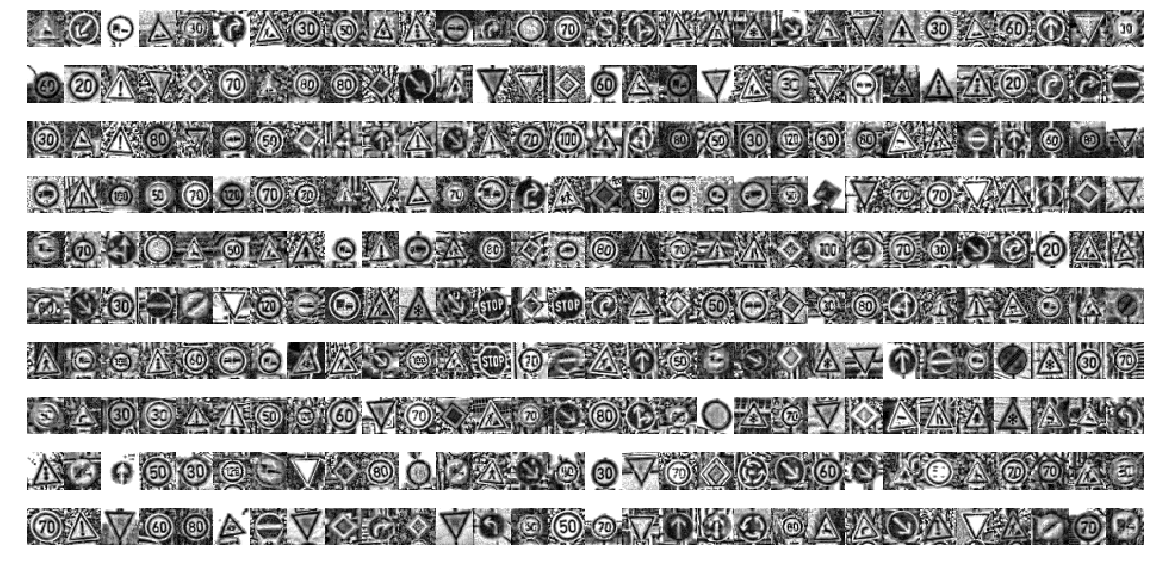

In [17]:
#PLOT 300 RANDOM IMAGES from PREPROCESSED training set
i = np.copy(X_train_preprocessed)

show_images(i, len(i), len(i), images_per_row = 30, images_per_col = 10, 
            H = 20, W = 10, its_gray = True)

### Model Architecture

In [18]:
def convolution(x, W, b, s = 1, with_relu = True, with_maxpool = False):
    result = tf.nn.conv2d(x, W, strides = [1, s, s, 1], padding = 'SAME')
    result = tf.nn.bias_add( result, b)
    if with_relu:
        result = tf.nn.relu(result)
    if with_maxpool:
        result = tf.nn.max_pool( result, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    return result

def fully_connected(x, W, b, keep_prob, do_flatten = True, with_relu = True):
    if do_flatten:
        x = flatten(x)
    result = tf.add(tf.matmul(x, W), b) 
    if with_relu:
        result = tf.nn.relu(result)
    result = tf.nn.dropout(result, keep_prob)
    return result
    
def network(x, W, b, dropout_prob):
    r = convolution(x, W['wc1'], b['bc1'], with_maxpool = True)
    r = convolution(r, W['wc2'], b['bc2'], with_maxpool = True)
    r = fully_connected(r, W['wf1'], b['bf1'], keep_prob = dropout_prob)
    r = fully_connected(r, W['wf2'], b['bf2'], keep_prob = dropout_prob, do_flatten = False, with_relu = False)
    return r 

In [19]:
output_size = 43 #number of classifiers/labels - n_classes
c = 1         
fs1 = 5       
fs2 = 5        
depth1 = 64  #32
depth2 = 32  #64
fc_out = 256 #1024


weights = {
    'wc1': tf.Variable(tf.truncated_normal(shape=(fs1, fs1, c, depth1), mean = 0, stddev = 0.1)),
    'wc2': tf.Variable(tf.truncated_normal(shape=(fs2, fs2, depth1, depth2), mean = 0, stddev = 0.1)),
    'wf1': tf.Variable(tf.truncated_normal(shape=(8*8*depth2, fc_out), mean = 0, stddev = 0.1)),
    'wf2': tf.Variable(tf.truncated_normal(shape=(fc_out, output_size), mean = 0, stddev = 0.1))  
}

biases = {
    'bc1': tf.Variable(tf.zeros(depth1)),
    'bc2': tf.Variable(tf.zeros(depth2)),
    'bf1': tf.Variable(tf.zeros(fc_out)),
    'bf2': tf.Variable(tf.zeros(output_size))
}

#CONV1_INPUT: 32x32x1 OUTPUT:32x32xdepth1 MAXPOOLOUTPUT: 16x16xdepth1
#CONV2_INPUT: 16x16xdepth1 OUTPUT: 16x16xdepth2 MAXPOOLOUTPUT: 8x8xdepth2
#FC1_INPUT: 8x8xdepth2 OUTPUT: 8x8xdepth2
#FC1_INPUT: 8x8xdepth2 OUTPUT: n_classes

In [23]:
LEARNING_RATE = 0.00005

EPOCHS = 100     
BATCH_SIZE = 32 #512

IMAGE_SIZE = 32
NUMBER_OF_CLASSES = 43           #n_classes
NUMBER_OF_TRAINING_DATA = 34799  #len(y_train)

LR = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, shape = (None, IMAGE_SIZE, IMAGE_SIZE, 1))
y = tf.placeholder(tf.int32, shape = (None))
one_hot_y = tf.one_hot(y, NUMBER_OF_CLASSES)
keep_prob = tf.placeholder(tf.float32) 

saver = tf.train.Saver()

logits = network(x, weights, biases, dropout_prob = keep_prob)

CROSS_ENTROPY_OPERATION = tf.nn.softmax_cross_entropy_with_logits(labels = one_hot_y, logits = logits)
LOSS_OPERATION = tf.reduce_mean(CROSS_ENTROPY_OPERATION)
OPTIMIZER_OPERATION = tf.train.AdamOptimizer(learning_rate = LR)
TRAINING_OPERATION = OPTIMIZER_OPERATION.minimize(LOSS_OPERATION)
INFERENCE_OPERATION = tf.argmax(logits, 1)
CORRECT_PREDICTION_OPERATION = tf.equal(INFERENCE_OPERATION, tf.argmax(one_hot_y, 1))
ACCURACY_OPERATION = tf.reduce_mean(tf.cast(CORRECT_PREDICTION_OPERATION, tf.float32))

In [24]:
def get_batch(X_data, y_data, start, BATCH_SIZE):
    end = start + BATCH_SIZE
    return X_data[start:end], y_data[start:end]

def evaluate(X_data, y_data):
    
    total_accuracy = 0
    total_samples = len(X_data)
    sess = tf.get_default_session()
    
    for start in range(0, total_samples, BATCH_SIZE):        
        batch_x, batch_y = get_batch(X_data, y_data, start, BATCH_SIZE) 
        params = {x: batch_x, y: batch_y, keep_prob: 1.0}
        accuracy = sess.run(ACCURACY_OPERATION, feed_dict= params)
        total_accuracy += (accuracy * len(batch_x))
    
    return total_accuracy / total_samples

### Train, Validate and Test the Model

In [25]:
# TRAIN THE MODEL

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())

    for epoch in range(EPOCHS):
        
        X_data, y_data = shuffle(X_train_preprocessed, y_train)
        
        for start in range(0, NUMBER_OF_TRAINING_DATA, BATCH_SIZE):
            
            batch_x, batch_y = get_batch(X_data, y_data, start, BATCH_SIZE)
            params = {x: batch_x, y: batch_y, keep_prob: 0.75, LR: LEARNING_RATE}
            _, loss = sess.run([TRAINING_OPERATION, LOSS_OPERATION], feed_dict = params)
            
        validation_accuracy = evaluate(X_valid_preprocessed, y_valid)
        
        print("{:3d}".format(epoch), "VA = {:.3f}".format(validation_accuracy), 
              "cost est= {:.3f}".format(loss))
        
    saver.save(sess, './model')
    print("Model saved")

  0 VA = 0.481 cost est= 2.751
  1 VA = 0.659 cost est= 1.522
  2 VA = 0.748 cost est= 1.693
  3 VA = 0.795 cost est= 1.065
  4 VA = 0.825 cost est= 1.066
  5 VA = 0.847 cost est= 1.104
  6 VA = 0.866 cost est= 1.329
  7 VA = 0.880 cost est= 0.605
  8 VA = 0.893 cost est= 0.728
  9 VA = 0.897 cost est= 1.125
 10 VA = 0.905 cost est= 0.856
 11 VA = 0.908 cost est= 1.236
 12 VA = 0.912 cost est= 0.386
 13 VA = 0.916 cost est= 1.231
 14 VA = 0.923 cost est= 0.492
 15 VA = 0.921 cost est= 0.651
 16 VA = 0.931 cost est= 0.913
 17 VA = 0.930 cost est= 0.936
 18 VA = 0.937 cost est= 0.833
 19 VA = 0.934 cost est= 0.528
 20 VA = 0.935 cost est= 0.655
 21 VA = 0.939 cost est= 1.162
 22 VA = 0.936 cost est= 1.101
 23 VA = 0.944 cost est= 0.804
 24 VA = 0.941 cost est= 1.010
 25 VA = 0.948 cost est= 1.067
 26 VA = 0.947 cost est= 1.209
 27 VA = 0.944 cost est= 0.992
 28 VA = 0.953 cost est= 0.502
 29 VA = 0.946 cost est= 0.752
 30 VA = 0.948 cost est= 0.869
 31 VA = 0.947 cost est= 0.310
 32 VA =

In [26]:
# EVALUATE USING TEST DATA 

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test_preprocessed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\model
Test Accuracy = 0.961


A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [28]:
# LOAD THE NEW IMAGES FROM THE INTERNET TO A NUMPY ARRAY

path = 'data/'
image_name = ['0-20speed','1-30speed',
              '12-priority-road','13-yield',
              '14-stop','17-no-entry',
              '18-general-caution','3-60speed',
              '36-go-straight-right', 
              '40-roundabout-mandatory']

image_list = []

for name in image_name:
    img = imread(path + name + '.png')
    img = imresize(img, (32, 32))
    image_list.append(img)

own_set_x = np.array(image_list)
own_set_x = preprocess(own_set_x)
own_set_x = reshape(own_set_x)
own_set_y = np.array([0, 1, 12, 13, 14, 17, 18, 3, 36, 40])
print(own_set_x.shape, own_set_y.shape)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


(10, 32, 32, 1) (10,)


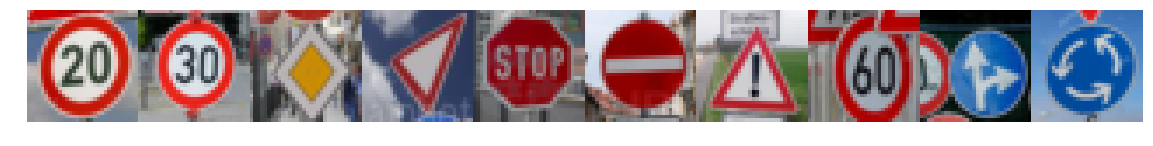

In [29]:
#show selected image from internet 

number_of_images = len(image_list)
figure, axis = plt.subplots(1, number_of_images, figsize=(20, 20))
figure.subplots_adjust(hspace = .2, wspace=.001)
axis = axis.ravel()
    
for i in range(number_of_images):     
    image = image_list[i]
    axis[i].axis('off')
    axis[i].imshow(image)

### Predict the Sign Type for Each Image

In [30]:
#CHECK HOW OUR SELECTED IMAGES FAIRED, AND ITS TOP 5 PREDICTION BASED on built-in top_k function 

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    OUT = sess.run(tf.argmax(logits, 1), feed_dict={x: own_set_x, y: own_set_y, keep_prob: 1.0})
    print("", OUT, "<-predictions")
    print("", own_set_y, "<-actual")

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    OUT = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 5), feed_dict={x: own_set_x, y: own_set_y, keep_prob: 1.0})
    print(OUT[1].T)
    print("(top  5 predictions above) for each image")
    
print()    
print("probability for top 5 predictions for each image:")
for i in range(len(own_set_y)):
    print(i, OUT[0][i].T)


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(own_set_x, own_set_y )
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\model
 [ 0  1 12 13 14 17 18  3 35 40] <-predictions
 [ 0  1 12 13 14 17 18  3 36 40] <-actual
INFO:tensorflow:Restoring parameters from .\model
[[ 0  1 12 13 14 17 18  3 35 40]
 [ 1  2 35  9 13  9 25 40 28 16]
 [37  5 34 12 40 40 11 34 36 17]
 [ 3  0 29 14  8 33 26 35 13 29]
 [16  6 17  5  7 14 35 11 41 42]]
(top  5 predictions above) for each image

probability for top 5 predictions for each image:
0 [9.9531770e-01 4.6172161e-03 5.1036513e-05 6.3344683e-06 3.9863876e-06]
1 [9.9931538e-01 6.6033035e-04 1.9873671e-05 2.1730491e-06 1.9384297e-06]
2 [1.0000000e+00 1.4937049e-09 4.1295550e-10 1.2604885e-10 1.1876503e-10]
3 [1.0000000e+00 1.1443543e-10 2.8195647e-12 1.9973545e-12 3.4958898e-13]
4 [9.9999607e-01 1.8705076e-06 1.1092098e-06 5.9816159e-07 1.8745480e-07]
5 [1.0000000e+00 4.1295864e-10 1.9108974e-12 1.4754280e-12 5.9550623e-13]
6 [1.0000000e+00 2.0357002e-12 1.1839058e-12 2.2722949e-13 7.0145272e-14]
7 [9.9823797e-01 1.6510708e-03 7.2

### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [25]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")